<a href="https://colab.research.google.com/github/AlexBB999/NLP/blob/master/Disaster2_T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Real or Not? NLP with Disaster Tweets**

**Predict which Tweets are about real disasters and which ones are not**

**THIS TWITTER DISASTER DATA COMES FROM KAGGLE**

**SINCE I AM NOT SUBMITTING TO KAGGLE, I WILL USE THE TRAINING DATA**

**FOR BOTH TRAINING AND TESTING**

In [0]:
import pandas as pd
import spacy
nlp = spacy.load("en")
import seaborn as sns, numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [0]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
df=pd.read_csv("https://raw.githubusercontent.com/AlexBB999/junk/master/twitter_train.csv")

**I NEED TO SEE THE ENTIRE TWEET -- REMOVING WIDTH CONSTRAINT**

In [0]:
pd.set_option('display.max_colwidth',-1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [0]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


**USED SPACEY FOR THIS TOKENIZATION -- USED ANOTHER TOKENIZER IN REST OF SUBMISSION**

In [0]:
df['tokens']=[len(nlp(x)) for x in df['text']]

In [0]:
df.head()

,id,keyword,location,text,target,tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,14
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,8
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,25
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,9
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,18


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
 5   tokens    7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB


**I AM NOT DROPPING ANYTHING SINCE I HAVE SO LITTLE DATA**

In [0]:
df.isnull().sum()

id          0   
keyword     61  
location    2533
text        0   
target      0   
tokens      0   
dtype: int64

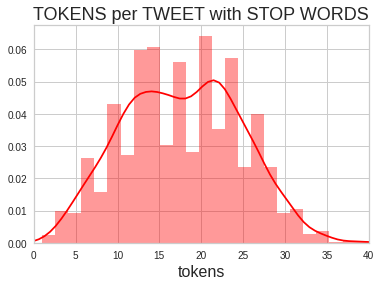

In [0]:
plt.title('TOKENS per TWEET with STOP WORDS', fontsize=18)
plt.xlabel('Number of Tokens', fontsize=16)
#plt.ylabel('Number of Tweets', fontsize=16)
plt.xlim([0.0,40.0])
g=sns.distplot(df['tokens'],color='red')

**//////////////////////////////////////////////////////////**

**CREATING ONE STRING FROM ALL TWEETS FOR WORD CLOUD ONLY**

In [0]:

word_clouds_words=[''.join(x) for x in df['text']]
w2=" ".join(word_clouds_words)

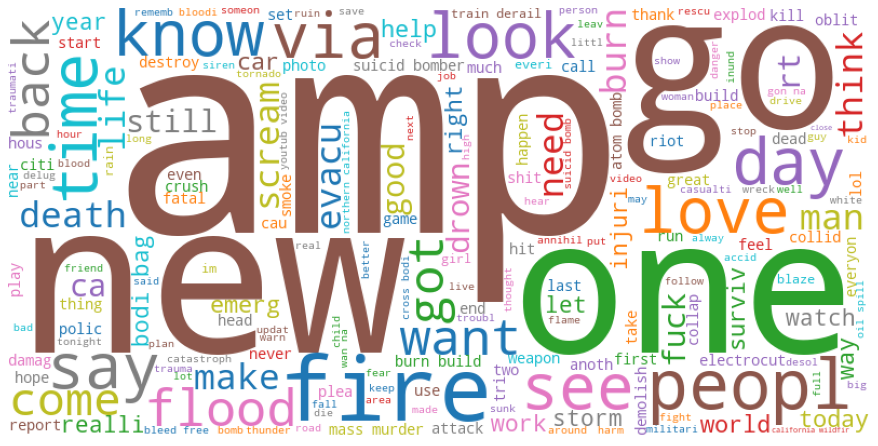

In [0]:
from wordcloud import WordCloud, STOPWORDS

def word_cloud(text, colormap='tab10', background_color='white'):
    cloud = WordCloud(width=800, height=400, stopwords=STOPWORDS,
                      colormap=colormap, 
                      background_color=background_color).generate(text)
    
    plt.figure(figsize=(12,10))
    plt.imshow(cloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

word_cloud(w2)

In [0]:
#df["text"]=df['text'][1:].reset_index(drop=True)

**MODIFIED VERSION OF NORMALIZING FUNCTION GIVEN IN CLASS**

In [0]:
docs=df['text']
def preprocess(docs):
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer('english')
    preprocessed = []
    
    for doc in docs:
        tokenized = word_tokenize(doc)

        cleaned = [stemmer.stem(lemmatizer.lemmatize(token.lower())) 
                   for token in tokenized 
                   if not token.lower() in stopwords.words('english') 
                   if not token.lower() in ('http')
                   
                   if token.isalpha()]

        untokenized = " ".join(cleaned)
        preprocessed.append(untokenized)
        
    return preprocessed

In [0]:
df['text']= preprocess(docs)

In [0]:
df['tokens']=[len(x) for x in df['text']]

In [0]:
df.head()

,id,keyword,location,text,target,tokens
0,1,NaN,NaN,deed reason earthquak may forgiv,1,32
1,4,NaN,NaN,forest fire near la rong sask canada,1,36
2,5,NaN,NaN,resid ask place notifi offic evacu shelter place order expect,1,61
3,6,NaN,NaN,peopl receiv wildfir evacu order california,1,43
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour school,1,52


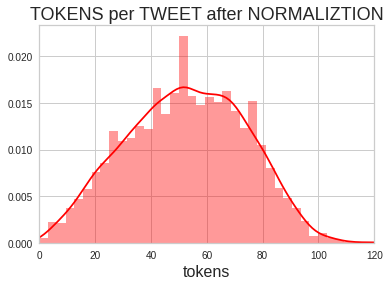

In [0]:
#sns.distplot(df['tokens'], kde=False, color='red', bins=100)
plt.title('TOKENS per TWEET after NORMALIZTION', fontsize=18)
plt.xlabel('Number of Tokens', fontsize=16)
#plt.ylabel('Number of Tweets', fontsize=16)
plt.xlim([0.0,120.0])
g=sns.distplot(df['tokens'],color='red')

##**SENTIMENT ANALYSIS**

**AFINN**

In [0]:
! pip install afinn
from afinn import Afinn

afn = Afinn()

In [0]:
sentiment=[afn.score(x) for x in df['text']]

In [0]:
#df['score']=[x for x in sentiment]

**CONVERT SCORE TO BINARY SO IT CAN BE COMPARED TO THE CORRECT LABEL**

In [0]:
score=[np.where(x,1,0) for x in sentiment]

In [0]:
df['afinn']=score

In [0]:
df.head()

,id,keyword,location,text,target,tokens,afinn
0,1,NaN,NaN,deed reason earthquak may forgiv,1,32,0
1,4,NaN,NaN,forest fire near la rong sask canada,1,36,1
2,5,NaN,NaN,resid ask place notifi offic evacu shelter place order expect,1,61,0
3,6,NaN,NaN,peopl receiv wildfir evacu order california,1,43,0
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour school,1,52,0


**ACCURACY**

In [0]:
(df['target']==df['afinn']).sum()/len(df['target'])

0.5028241166425851

**ABOUT THE SAME AS GUESSING**

**/////////////////////////////////////////////////////**

**VADER**

In [0]:
pip install vaderSentiment

In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [0]:
df['vader'] =[analyser.polarity_scores(x)['neg'] for x in df['text']]

**CONVERT SCORE TO BINARY**

**ASSIGNING 0 TO ANYTHING THAT HAS NEGATIVE>=0**

In [0]:
df['vader']=[np.where(x,1,0) for x in df['vader']]

In [0]:
df.head()

,id,keyword,location,text,target,tokens,afinn,vader
0,1,NaN,NaN,deed reason earthquak may forgiv,1,32,0,0
1,4,NaN,NaN,forest fire near la rong sask canada,1,36,1,1
2,5,NaN,NaN,resid ask place notifi offic evacu shelter place order expect,1,61,0,0
3,6,NaN,NaN,peopl receiv wildfir evacu order california,1,43,0,0
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour school,1,52,0,0


**ACCURACY**

In [0]:
(df['target']==df['vader']).sum()/len(df['target'])

0.5691580191777224

**A LITTLE BETTER THAN GUESSING**

**////////////////////////////////////////////////////////////**

##**USING MACHINE LEARNING**

**CREATE TRAINING AND TEST VECTORS**




In [0]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [0]:
X=df['text']
y=df['target']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

**THE SIMPLEST VECTORIZER -- COUNTVECTORIZER**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(binary=True)
cv.fit(X_train)
X_train = cv.transform(X_train)
X_test = cv.transform(X_test)

In [0]:
from sklearn.linear_model import LogisticRegression

for c in [0.05, 0.25, 0.5, 1,10]:
    
    lr = LogisticRegression(C=c,max_iter=200)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_train, lr.predict(X_train))))

Accuracy for C=0.05: 0.8354679802955665
Accuracy for C=0.25: 0.8929392446633826
Accuracy for C=0.5: 0.9221674876847291
Accuracy for C=1: 0.9451559934318555
Accuracy for C=10: 0.9853858784893268


**C=10 LOOKS BEST BUT MAY OVERFIT**

**TEST C VALUES ON TEST SET**

In [0]:
for c in [0.05, 0.25, 0.5, 1,10]:
    
    lr = LogisticRegression(C=c,max_iter=200)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))

Accuracy for C=0.05: 0.7997373604727511
Accuracy for C=0.25: 0.8115561391989494
Accuracy for C=0.5: 0.8030203545633617
Accuracy for C=1: 0.7872619829284307
Accuracy for C=10: 0.7642810242941562


C=.25 BEST RESULTS

**81% ACCURACY ON TEST SET -- MUCH BETTER -- STILL COULD USE SEPERATE TEST SET**



**////////////////////////////////////////////////////////////////**

**TRY WITH 1 AND 2 NGRAMS**

In [0]:
cv = CountVectorizer(binary=True, ngram_range=(1, 2))

In [0]:
cv.fit(X_train)
X_train = cv.transform(X_train)
X_test = cv.transform(X_test)

In [0]:
for c in [0.05, 0.25, 0.5, 1,10]:
    
    lr = LogisticRegression(C=c,max_iter=200)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_train, lr.predict(X_train))))

Accuracy for C=0.05: 0.8688013136288998
Accuracy for C=0.25: 0.9520525451559935
Accuracy for C=0.5: 0.9711001642036124
Accuracy for C=1: 0.9827586206896551
Accuracy for C=10: 0.9876847290640394


**TEST SET**

In [0]:
for c in [0.05, 0.25, 0.5, 1,10]:
    
    lr = LogisticRegression(C=c,max_iter=200)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))

Accuracy for C=0.05: 0.8056467498358503
Accuracy for C=0.25: 0.8069599474720945
Accuracy for C=0.5: 0.8063033486539725
Accuracy for C=1: 0.8023637557452397
Accuracy for C=10: 0.788575180564675


**ACCURACY ABOUT THE SAME**

**I ALSO TRIED TF-IDF -- WITH EVEN WORSE RESULTS**